# Outline

In this notebook we use [Random Forest](https://en.wikipedia.org/wiki/Random_forest) and [Gradiant Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) to predict customer churn based on the [Telco Customer Churn](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) dataset. 

For a fairly in-depth analysis of this dataset, see the [Feature Analysis and Engineering](https://github.com/sedihub/ml_explorations/blob/main/telco_customer_churn/feature_analysis_and_engineering.ipynb) notebook.

<br><br><br>

Import Sci Kit Learn, NumPy, Pandas, and MatplotLib: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,\
                            log_loss,\
                            classification_report,\
                            roc_curve,\
                            roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier,\
                             RandomForestClassifier

import utilities as utils

<br><br><br>

# Dataset

## Load Dataset and Present a Summary

In [2]:
df = pd.read_csv("telco_customer_churn.csv")
display(df.sample(10))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1159,4086-YQSNZ,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.40,224.05,Yes
3354,7029-IJEJK,Female,0,No,No,54,No,No phone service,DSL,Yes,...,No,Yes,No,Yes,One year,No,Bank transfer (automatic),44.10,2369.7,No
86,4808-YNLEU,Female,0,Yes,No,35,Yes,No,DSL,Yes,...,No,No,Yes,No,One year,Yes,Bank transfer (automatic),62.15,2215.45,No
5756,6349-JDHQP,Female,0,No,No,53,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.85,1049.6,No
4653,2091-MJTFX,Female,0,Yes,Yes,30,No,No phone service,DSL,No,...,No,Yes,Yes,Yes,Month-to-month,No,Credit card (automatic),51.20,1561.5,Yes
2933,5220-AGAAX,Male,0,Yes,Yes,68,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),24.00,1664.3,No
4571,0599-XNYDO,Female,0,Yes,No,20,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),69.80,1540.35,No
1029,4184-TJFAN,Female,1,Yes,Yes,3,Yes,No,Fiber optic,Yes,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,88.30,273.75,Yes
5476,6060-DRTNL,Female,1,No,No,5,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Mailed check,84.85,415.55,Yes
125,4622-YNKIJ,Male,0,No,No,33,Yes,No,Fiber optic,Yes,...,No,Yes,Yes,No,Two year,Yes,Electronic check,88.95,3027.65,No


In [3]:
# Summary of features:
print(f"Num Rows: {len(df.index)}")

for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:24}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:24}{str(df[col].dtype):16}")

Num Rows: 7043
	customerID              object          ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	gender                  object          ['Female' 'Male']
	SeniorCitizen           int64           
	Partner                 object          ['Yes' 'No']
	Dependents              object          ['No' 'Yes']
	tenure                  int64           
	PhoneService            object          ['No' 'Yes']
	MultipleLines           object          ['No phone service' 'No' 'Yes']
	InternetService         object          ['DSL' 'Fiber optic' 'No']
	OnlineSecurity          object          ['No' 'Yes' 'No internet service']
	OnlineBackup            object          ['Yes' 'No' 'No internet service']
	DeviceProtection        object          ['No' 'Yes' 'No internet service']
	TechSupport             object          ['No' 'Yes' 'No internet service']
	StreamingTV             object          ['No' 'Yes' 'No internet service']
	StreamingMovies         object  

In [4]:
# Fraction of cancellations:
print("\tCustomer Churn: {}".format(
    round(float(np.sum(df["Churn"].apply(lambda x: 1 if x == "Yes" else 0).values) / len(df.index)), 3)))

	Customer Churn: 0.265


## Convert Categorical to One-Hot-Encoding:

We first drop "customerID" and "TotalCharges" (see the analysis notebook for the reason). Then we combine some of the categories such as "No internet service" and "No" for internet-related features. Similarly, we binarize "Contract" and "PaymentMethod" features.

Finally, we convert categorical features to one-hot encoding. We will later decide if we want to exclude some of the internet-related features.

In [5]:
# Drop total charges:
df = df.drop(["TotalCharges"], axis=1)
df = df.drop(["customerID"], axis=1)

# Combine some feature values:
df["Contract"] = df["Contract"].apply(lambda x: "No" if x == "Month-to-month" else "Yes")
df["PaymentMethod"] = df["PaymentMethod"].apply(lambda x: "Mailed" if x == "Mailed check" else "Electronic")
df["MultipleLines"] = df["MultipleLines"].apply(lambda x: "Yes" if x == "Yes" else "No")
for col_name in ["OnlineSecurity", "OnlineBackup", 
                 "DeviceProtection", "TechSupport", 
                 "StreamingTV", "StreamingMovies"]:
    df[col_name] = df[col_name].apply(lambda x: "Yes" if x == "Yes" else "No")
    

df["Churn"] = df["Churn"].apply(lambda x: True if x == "Yes" else False).astype(int)

# Print summary:
for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:24}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:24}{str(df[col].dtype):16}")

	gender                  object          ['Female' 'Male']
	SeniorCitizen           int64           
	Partner                 object          ['Yes' 'No']
	Dependents              object          ['No' 'Yes']
	tenure                  int64           
	PhoneService            object          ['No' 'Yes']
	MultipleLines           object          ['No' 'Yes']
	InternetService         object          ['DSL' 'Fiber optic' 'No']
	OnlineSecurity          object          ['No' 'Yes']
	OnlineBackup            object          ['Yes' 'No']
	DeviceProtection        object          ['No' 'Yes']
	TechSupport             object          ['No' 'Yes']
	StreamingTV             object          ['No' 'Yes']
	StreamingMovies         object          ['No' 'Yes']
	Contract                object          ['No' 'Yes']
	PaperlessBilling        object          ['Yes' 'No']
	PaymentMethod           object          ['Electronic' 'Mailed']
	MonthlyCharges          float64         
	Churn                   int64    

In [6]:
columns = [
    "gender", "Partner", "Dependents", "PhoneService",
    "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", 
    "StreamingTV", "StreamingMovies", "Contract", 
    "PaperlessBilling", "PaymentMethod"]
prefixes = [
    "gender", "partner", "dependents", "phone service", 
    "multiple lines", "internet service", "online security",
    "online backup", "device protection", "tech support", 
    "streaming tv", "streaming movies", "contract", 
    "paperless billing", "payment method"]
df = pd.get_dummies(
    df, 
    prefix=prefixes, 
    prefix_sep=' ', 
    dummy_na=False, 
    columns=columns, 
    sparse=False, 
    drop_first=False, 
    dtype=int)

# Print summary:
for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:32}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:32}{str(df[col].dtype):16}")

	SeniorCitizen                   int64           
	tenure                          int64           
	MonthlyCharges                  float64         
	Churn                           int64           
	gender Female                   int64           
	gender Male                     int64           
	partner No                      int64           
	partner Yes                     int64           
	dependents No                   int64           
	dependents Yes                  int64           
	phone service No                int64           
	phone service Yes               int64           
	multiple lines No               int64           
	multiple lines Yes              int64           
	internet service DSL            int64           
	internet service Fiber optic    int64           
	internet service No             int64           
	online security No              int64           
	online security Yes             int64           
	online backup No                int64           


<br><br><br>

# Predicting Customer Churn

Here we tray to predict customer churn using Random Forest and Gradient Boosting classifiers, which are two powerful ensemble classifiers. We first decompose the dataset into train and test sets.

## Decompose into Train and Test Sets:

In [7]:
churn_array = df["Churn"].values
df = df.drop(["Churn"], axis=1)

feature_names = df.columns
features_array = df.values
del df

print(f"\tTargets:  {churn_array.shape}")
print(f"\tFeatures: {features_array.shape}")

	Targets:  (7043,)
	Features: (7043, 34)


In [8]:
total_num_samples = churn_array.shape[0]
test_set_size = int(0.2 * total_num_samples)

index_mask_array = np.arange(total_num_samples)
np.random.shuffle(index_mask_array)

y_train = churn_array[index_mask_array[test_set_size:]]
x_train = features_array[index_mask_array[test_set_size:], ...]

y_test = churn_array[index_mask_array[:test_set_size]]
x_test = features_array[index_mask_array[:test_set_size], ...]

print(f"\tx_train {x_train.shape}, y_train {y_train.shape}")
print(f"\tx_test {x_test.shape}, y_test {y_test.shape}")

	x_train (5635, 34), y_train (5635,)
	x_test (1408, 34), y_test (1408,)


<br> 
## Random Forest Classifier

In [9]:
random_forest_classifier = RandomForestClassifier(
    n_estimators=100, 
    criterion="gini", 
    max_depth=5,  # roughly log(34) 
    min_samples_split=20, 
    min_samples_leaf=10, 
    min_weight_fraction_leaf=0.0, 
    max_features="auto", 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight={0: 0.256, 1:0.735},  # The dataset is not balanced!
    ccp_alpha=0.0, 
    max_samples=None)

# Train
random_forest_classifier.fit(x_train, y_train)

# Predict
y_pred = random_forest_classifier.predict(x_train)
print(classification_report(y_train, y_pred, target_names=["Cancelled", "Stayed"]))

# # Confusion matrix 
# conf_mat = confusion_matrix(y_train, y_pred)
# utils.plot_binary_confusion_matrix(conf_mat)

              precision    recall  f1-score   support

   Cancelled       0.92      0.71      0.80      4125
      Stayed       0.51      0.83      0.63      1510

    accuracy                           0.74      5635
   macro avg       0.72      0.77      0.72      5635
weighted avg       0.81      0.74      0.76      5635



Evaluate on the test set:

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1049
           1       0.48      0.81      0.60       359

    accuracy                           0.73      1408
   macro avg       0.70      0.76      0.70      1408
weighted avg       0.80      0.73      0.75      1408



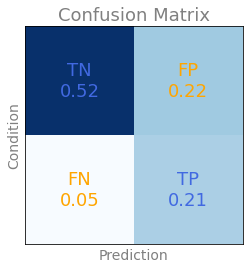

In [10]:
# Predict and print report:
y_pred = random_forest_classifier.predict(x_test)
print(classification_report(y_test, y_pred))

# Confusion matrix:
conf_mat = confusion_matrix(y_test, y_pred)
utils.plot_binary_confusion_matrix(conf_mat)

<br> 
## Gradient Boosting Classifier

In [11]:
gb_classifier = GradientBoostingClassifier(
    loss="deviance", 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion="friedman_mse", 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=None, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001, 
    ccp_alpha=0.0)

# Train
gb_classifier.fit(
    x_train, y_train, sample_weight=np.where(y_train == 1, 0.735, 0.265))

# Predict
y_pred = gb_classifier.predict(x_train)
print(classification_report(y_train, y_pred, target_names=["Cancelled", "Stayed"]))

# # Confusion matrix 
# conf_mat = confusion_matrix(y_train, y_pred)
# utils.plot_binary_confusion_matrix(conf_mat)

              precision    recall  f1-score   support

   Cancelled       0.93      0.74      0.82      4125
      Stayed       0.54      0.84      0.65      1510

    accuracy                           0.76      5635
   macro avg       0.73      0.79      0.74      5635
weighted avg       0.82      0.76      0.78      5635



Evaluate on the test set:

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1049
           1       0.51      0.82      0.63       359

    accuracy                           0.76      1408
   macro avg       0.72      0.78      0.72      1408
weighted avg       0.82      0.76      0.77      1408



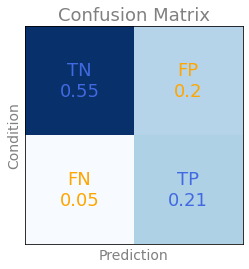

In [12]:
# Predict and print report:
y_pred = gb_classifier.predict(x_test)
print(classification_report(y_test, y_pred))

# Confusion matrix:
conf_mat = confusion_matrix(y_test, y_pred)
utils.plot_binary_confusion_matrix(conf_mat)